In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [2]:
size = 32
def generate_transients(x_centre,y_centre, size=size):
    sigma_x = 2.
    sigma_y = 2.

    x = np.linspace(0, 32, size)
    y = np.linspace(0, 32, size)

    x, y = np.meshgrid(x, y)

    z = np.exp(-((x-x_centre)**2/(2*sigma_x**2) + (y-y_centre)**2/(2*sigma_y**2)))

    z = z/np.max(z)
    z[z<0.1] = 0.
    return z

In [9]:
N = 30000
np.random.seed(42)
centres = np.random.randint(27,size=(N,2))+3

In [10]:
img = np.empty((N,size,size))
for i in range(N):
    img[i,:,:] = generate_transients(centres[i,0],centres[i,1])

In [11]:
nothing = np.random.choice(N,size=N//2)
img[nothing,:,:]=np.zeros((size,size))
centres[nothing] = np.array([0,0])

In [12]:
noise = noise = np.random.normal(loc=0.0, scale=0.5, size=img.shape)

In [13]:
noisy_img = img + noise

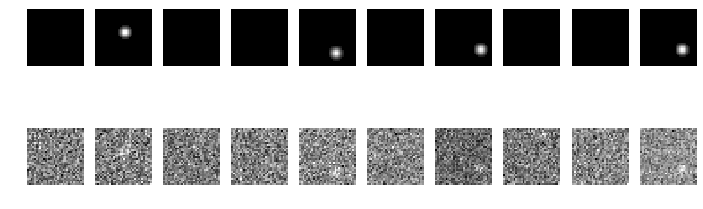

In [14]:
plt.figure(figsize=(12,4))
plt.tight_layout()
for i in range(10):
    a = plt.subplot(2,10,i+1)
    a.axis('off')
    plt.gray()
    a.imshow(img[i])
    a = plt.subplot(2,10,10+i+1)
    plt.gray()
    a.imshow(noisy_img[i])
#     a.axhline(centres[i,1],color='white',linestyle=":")
#     a.axvline(centres[i,0],color='white',linestyle=":")
    
    a.axis('off')

In [15]:
np.savez('../data/transient_images',transients=img,noisy=noisy_img, centres=centres)

In [16]:
!ls -lh ../data/transient_images.npz

-rw-r--r--@ 1 toast  staff   469M Feb  4 14:58 ../data/transient_images.npz


In [17]:
dataset = np.load('../data/transient_images.npz')
img = dataset['transients']
noisy_img = dataset['noisy']
centres = dataset['centres']

In [18]:
img = img.reshape(-1,size,size,1)
noisy_img = noisy_img.reshape(-1,size,size,1)

In [19]:
img.shape

(30000, 32, 32, 1)

In [20]:
img_rows, img_cols, channels = img[0].shape

In [21]:
N = len(img)
print(N)

30000


In [22]:
# from keras.models import Sequential
# ac = Sequential()
# ac.add(Conv2D(32, (3, 3), input_shape=(img_rows, img_cols, channels), activation='relu', padding='same'))
# ac.add(MaxPooling2D((2, 2), padding='same'))

# ac.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# ac.add(MaxPooling2D((2, 2), padding='same'))

# ac.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# ac.add(UpSampling2D((2, 2)))

# ac.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
# ac.add(UpSampling2D((2, 2)))

# ac.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# ac.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# ac.summary()

In [24]:
# from keras.layers import Conv2DTranspose
# input_img = Input(shape=(img_rows, img_cols, channels))  # adapt this if using `channels_first` image data format

# _x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# _x = MaxPooling2D((2, 2), padding='same')(_x)

# _x = Conv2D(32, (3, 3), activation='relu', padding='same')(_x)
# encoded = MaxPooling2D((2, 2), padding='same')(_x)

# # at this point the representation is (7, 7, 32)

# _x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(encoded)

# _x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(_x)

# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(_x)

# autoencoder_withConvT = Model(input_img, decoded)
# autoencoder_withConvT.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# autoencoder_withConvT.summary()

In [26]:
input_img = Input(shape=(img_rows, img_cols, channels))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (8, 8, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 32)        0         
__________

In [28]:
from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="autoencoder-weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
# try verbose=1
callbacks_list = [checkpoint]

In [29]:
# M = 3*N//4
# ac.fit(noisy_img[0:M], img[0:M],
#                 epochs=10,
#                 batch_size=128,
#                 shuffle=True,
#                 #callbacks=callbacks_list,
#                 validation_data=(noisy_img[M:], img[M:]))

In [30]:
M = 3*N//4
autoencoder.fit(noisy_img[0:M], img[0:M],
                epochs=10,
                batch_size=128,
                shuffle=True,
                # callbacks=callbacks_list,
                validation_data=(noisy_img[M:], img[M:]))

Train on 22500 samples, validate on 7500 samples
Epoch 1/10
22500/22500 [==============================] - 89s 4ms/step - loss: 0.0586 - acc: 0.9645 - val_loss: 0.0233 - val_acc: 0.9686
Epoch 2/10
22500/22500 [==============================] - 143s 6ms/step - loss: 0.0221 - acc: 0.9684 - val_loss: 0.0209 - val_acc: 0.9686
Epoch 3/10
22500/22500 [==============================] - 131s 6ms/step - loss: 0.0207 - acc: 0.9684 - val_loss: 0.0201 - val_acc: 0.9686
Epoch 4/10
22500/22500 [==============================] - 129s 6ms/step - loss: 0.0200 - acc: 0.9684 - val_loss: 0.0197 - val_acc: 0.9686
Epoch 5/10
22500/22500 [==============================] - 103s 5ms/step - loss: 0.0197 - acc: 0.9684 - val_loss: 0.0194 - val_acc: 0.9686
Epoch 6/10
22500/22500 [==============================] - 96s 4ms/step - loss: 0.0196 - acc: 0.9684 - val_loss: 0.0193 - val_acc: 0.9686
Epoch 7/10
22500/22500 [==============================] - 98s 4ms/step - loss: 0.0194 - acc: 0.9684 - val_loss: 0.0193 - val_

In [31]:
# autoencoder.load_weights("autoencoder-weights.best.hdf5")
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

<Figure size 432x288 with 0 Axes>

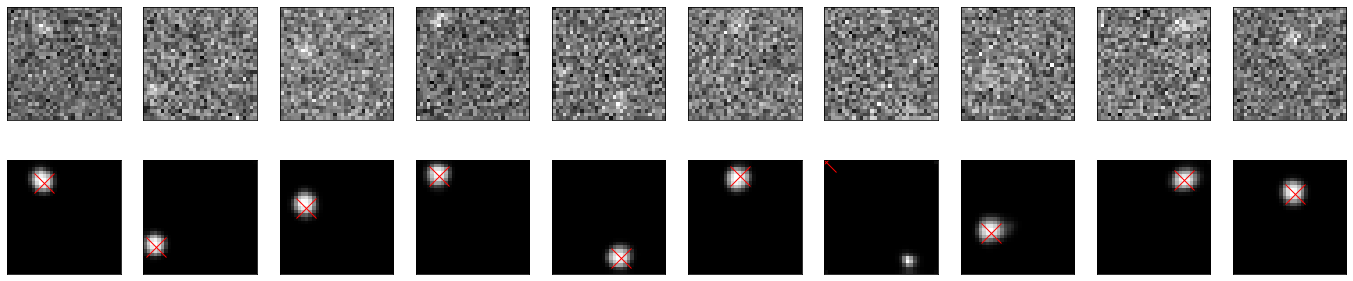

In [32]:
decoded_imgs = autoencoder.predict(noisy_img[M:])
plt.tight_layout()
n = 10
plt.figure(figsize=(24, 8))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(noisy_img[M+i].reshape(size, size))
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(size, size))
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.plot(centres[M+i,0],centres[M+i,1],'rx',fillstyle='none',markersize=20)

In [33]:
# estimate accuracy on test dataset using final weights
scores = autoencoder.evaluate(noisy_img[M:], img[M:], verbose=0)
print("%s: %.2f%%" % (autoencoder.metrics_names[1], scores[1]*100))

acc: 96.86%


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


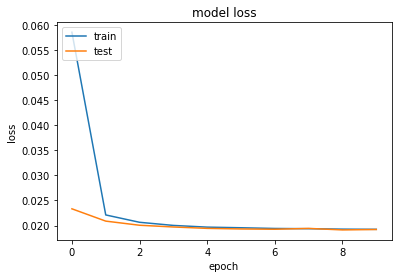

In [34]:
# summarize history for loss/acc
history = autoencoder.history
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

<Figure size 432x288 with 0 Axes>

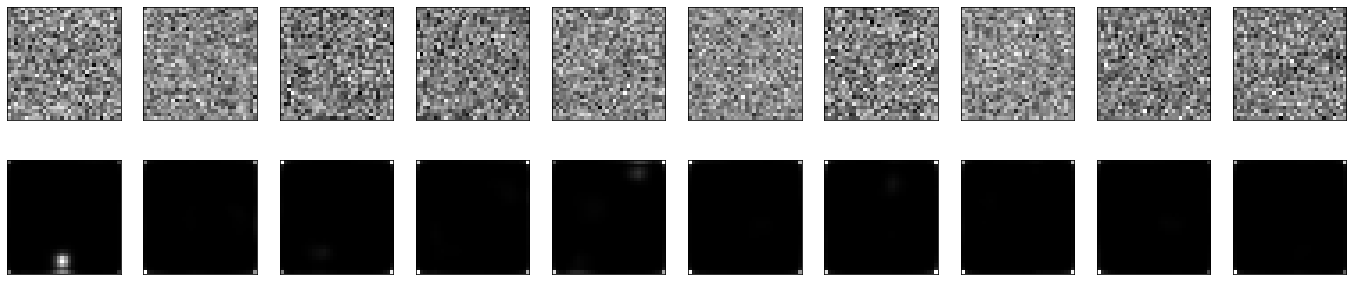

In [35]:
#noise = noise.reshape(img.shape)
just_noise = noisy_img[nothing]
decoded_noise = autoencoder.predict(just_noise)
plt.tight_layout()
n = 10
plt.figure(figsize=(24, 8))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(just_noise[i].reshape(size, size))
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_noise[i].reshape(size, size))
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [36]:
# estimate accuracy on test dataset using final weights
scores = autoencoder.evaluate(just_noise, np.zeros_like(just_noise), verbose=0)
print("%s: %.2f%%" % (autoencoder.metrics_names[1], scores[1]*100))

acc: 100.00%


In [37]:
just_noise.shape, decoded_noise.shape

((15000, 32, 32, 1), (15000, 32, 32, 1))